<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: calwebb_image2, NIRCam imaging

<span style="color:red"> **Instruments Affected**</span>: e.g., NIRCam 

### Table of Contents

<div style="text-align: left"> 
    
<br> [Introduction\*](#intro)
<br> [JWST CalWG Algorithm\*](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description\*](#description)
<br> [Data Description\*](#data_descr)
<br> [Imports\*](#imports)
<br> [Convenience Functions](#convenience_functions)
<br> [Loading the Data\*](#download_data)
<br> [calwebb_image2 - Calibrated slope images](#image2) 
<br> [Run the entire pipeline](#image2_at_once)
<br> [Run the individual pipeline steps](#image2_step_by_step)
    <br> [The `WCS Creation` step](#assign_wcs)
    <br> [The `Flat Fielding` step](#flatfield)
    <br> [The `Photometric calibration` step](#photom)
    <br> [The `Resample` step](#resample)
<br> [About This Notebook\*](#about)
<br>    

</div>

<a id='intro'></a>
# Introduction

This is the validation notebook for Stage 2 of the JWST imaging calibration pipeline, also known as *calwebb_image2*. The [Stage 2 imaging pipeline](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_image2.html#calwebb-detector2)  applies instrumental corrections and calibrations to the slope images output from Stage 1. This includes background subtraction, the creation of a full World Coordinate System (WCS) for the data, application of the flat field, and flux calibration. In most cases the final output is an image in units of surface brightness. In addition to the steps above, the Stage 2 pipeline will also run the [resample](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/main.html) step on the calibrated images, in order to remove the effects of instrument distortion. This step outputs files with the suffix `*_i2d.fits*` that contain "rectified" images. However, these files are meant only for user examination of the data. It is the `*_cal.fits*` files that are passed on to Stage 3 of the pipeline.

All JWST imaging mode data, regardless of instrument, are processed through the *calwebb\_image2* pipeline. The steps and the order in which they are performed is the same for all data.

Pipeline description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst

[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm

Individual exposures from the imaging modes are processed from counts/sec to absolute flux units. Nominally, this stage works on individual exposures. The current status of the algorithms for this pipeline stage is summarized below. Links are provided to individual pages where the details of the algorithms are given along with notes on why those algorithms were picked.

The algorithms for each step in each pipeline stage are split into "baseline" and "enhanced" versions (formerly known as "vanilla" and "optimal", respectively).  See Baseline and Enhanced Algorithms for more details.
Input/Outputs of this stage refer to the main data products for the pipeline process.  The full list of archive products for this (and all stages of the pipeline) is tabulated in Archive Products.

[JWST CalWG algorithms for calwebb_image2](https://outerspace.stsci.edu/display/JWSTCC/CALWEBB_IMAGE2)

[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms


**JWST**: James Webb Space Telescope

**NIR**: Near Infrared


[Top of Page](#title_ID)

<a id="description"></a>
# Test Description

This test is performed by running simulated data through the full pipeline and performing a visual inspection of the outputs. Next, the notebook does quick checks after each step in the calwebb_image2 pipeline, based on the algorithms defined. 


[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

For this module, we will use an association of calibrated NIRCam simulated imaging exposures generated with Mirage.


[Top of Page](#title_ID)

<a id="tempdir"></a>
# Set up Temporary Directory
The following cell sets up a temporary directory (using python's `tempfile.TemporaryDirectory()`), and changes the script's active directory into that directory (using python's `os.chdir()`). This is so that, when the notebook is run through, it will download files to (and create output files in) the temporary directory rather than in the notebook's directory. This makes cleanup significantly easier (since all output files are deleted when the notebook is shut down), and also means that different notebooks in the same directory won't interfere with each other when run by the automated webpage generation process.

If you want the notebook to generate output in the notebook's directory, simply don't run this cell.

If you have a file (or files) that are kept in the notebook's directory, and that the notebook needs to use while running, you can copy that file into the directory (the code to do so is present below, but commented out).

[Top of Page](#title_ID)

In [1]:
#****
#
# Set this variable to False to not use the temporary directory
#
#****
use_tempdir = True

# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil

if use_tempdir:
    data_dir = TemporaryDirectory()

    # If you have files that are in the notebook's directory, but that the notebook will need to use while
    # running, copy them into the temporary directory here.
    #
    # files = ['name_of_file']
    # for file_name in files:
    #     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

    # Save original directory
    orig_dir = os.getcwd()

    # Move to new directory
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpoo5z946t


## If Desired, set up CRDS to use a local cache

By default, the notebook template environment sets up its CRDS cache (the "CRDS_PATH" environment variable) in /grp/crds/cache. However, if the notebook is running on a local machine without a fast and reliable connection to central storage, it makes more sense to put the CRDS cache locally. Currently, the cell below offers several options, and will check the supplied boolean variables one at a time until one matches.

* if `use_local_crds_cache` is False, then the CRDS cache will be kept in /grp/crds/cache
* if `use_local_crds_cache` is True, the CRDS cache will be kept locally
  * if `crds_cache_tempdir` is True, the CRDS cache will be kept in the temporary directory
  * if `crds_cache_notebook_dir` is True, the CRDS cache will be kept in the same directory as the notebook.
  * if `crds_cache_home` is True, the CRDS cache will be kept in $HOME/crds/cache
  * if `crds_cache_custom_dir` is True, the CRDS cache will be kept in whatever is stored in the 
    `crds_cache_dir_name` variable.

If the above cell (creating a temporary directory) is not run, then setting `crds_cache_tempdir` to True will store the CRDS cache in the notebook's directory (the same as setting `crds_cache_notebook_dir` to True).

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id="imports"></a>
# Imports

Import packages necessary for this notebook

In [3]:
# Packages that allow us to get information about objects:
from glob import glob
import os
import shutil

# Numpy library:
import numpy as np

# To read association file
import json

# To download data
import requests

# To examine parameter reference files
import asdf

# Astropy tools:
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch

Set up matplotlib for plotting

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

Import JWST pipeline-related modules

In [5]:
# The entire calwebb_image2 pipeline
from jwst.pipeline import calwebb_image2

# Individual steps that make up calwebb_image2
from jwst.background import BackgroundStep
from jwst.assign_wcs import AssignWcsStep
from jwst.flatfield import FlatFieldStep
from jwst.photom import PhotomStep
from jwst.resample import ResampleStep
from jwst import datamodels

Check which version of the pipeline we are running:

In [6]:
import jwst
print(jwst.__version__)

1.4.3


<a id='convenience_functions'></a>
# Define convenience functions and parameters

Here we define some functions that we will use repeatedly throughout the notebook.

In [7]:
# Files created in this notebook will be saved
# in the current working directory
output_dir = './'

In [8]:
def show_image(data_2d, vmin, vmax, xpixel=None, ypixel=None, title=None,
               scale='log', units='MJy/str'):
    """Function to generate a 2D, log-scaled image of the data, 
    with an option to highlight a specific pixel.
    
    Parameters
    ----------
    data_2d : numpy.ndarray
        2D image to be displayed
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    xpixel : int
        X-coordinate of pixel to highlight
        
    ypixel : int
        Y-coordinate of pixel to highlight
        
    title : str
        String to use for the plot title
        
    scale : str
        Specify scaling of the image. Can be 'log' or 'linear'
        
    units : str
        Units of the data. Used for the annotation in the
        color bar
    """
    if scale == 'log':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    elif scale == 'linear':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LinearStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker='o', color='red', label='Selected Pixel')

    fig.colorbar(im, label=units)
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    if title:
        plt.title(title)

[Top of Page](#title_ID)

<a id="data_load"></a>
# Loading the Data

For this module, we will use rate files from a NIRCam simulated imaging exposure that is stored in Box. Let's grab them:

Download the rate files, association file, and parameter reference file, so that we have inputs to work with.

In [9]:
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)
        
file_urls = ['https://stsci.box.com/shared/static/g6316wjr4mv936rlouzdjeq065s7ou6g.fits',
             'https://stsci.box.com/shared/static/z2xunff1d2g3m3fjxc1fixoz8rjfpl7h.fits',
             'https://stsci.box.com/shared/static/4xuvt56kr7gix7dx3tntek6wc9kockef.fits',
             'https://stsci.box.com/shared/static/lzhcnzds2l7mpf92oet1u69uof788u3l.json',
             'https://stsci.box.com/shared/static/d4pu8ieyjc27wzoe0of3ajb9vjtvc80g.asdf']

file_names = ['jw98765001001_01101_00001_nrcb5_rate.fits',
              'jw98765001001_01101_00002_nrcb5_rate.fits',
              'jw98765001001_01101_00003_nrcb5_rate.fits',
              'level2_lw_asn.json',
              'image2_pipeline_params.asdf']   

box_download_list = [(url,name) for url,name in zip(file_urls,file_names)]

In [10]:
get_box_files(box_download_list)

[Top of Page](#title_ID)

---
<a id='image2'></a>
# The calwebb_image2 pipeline: Calibrated slope images

In the sections below, we will run the Stage 2 pipeline using an association file containing several NIRCam exposures. We will first call the entire *calwebb_image2* pipeline itself. The pipeline is a wrapper which will string together all of the appropriate steps in the proper order. The final outputs from this call are a calibrated slope image which is ready to go into the Stage 3 pipeline (with a suffix of `_cal.fits`), as well as a calibrated slope image which has been resampled in order to remove distortion effects (with a suffix of `_i2d.fits`). The latter is only for user-examination. The `_cal.fits` file is used as input to the Stage 3 pipeline. Note that the units in these output images are now physical units (MJy/str), rather than DN/sec.

After running the entire pipeline, we will go back to the original uncalibrated slope images and manually run them through each of the steps that comprise the Stage 2 pipeline. For each step we will examine the output.

See [Figure 1](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline/stages-of-processing/calwebb_image2) on the calwebb_image2 algorithm page for a map of the steps are performed on the input data.

<a id='image2_at_once'></a>
# Run the entire `calwebb_image2` pipeline

In this section we run the entire calwebb_image2 pipeline with a single call. 

We set parameter values for some of the individual steps, save some outputs, etc, and then call the pipeline.

We will call the pipeline using the `run()` method, examine some of the pipeline log entries that are printed to the screen, and then look at the pipeline output.

In [11]:
# Create an instance of the pipeline class
image2 = calwebb_image2.Image2Pipeline()

# Set some parameters that pertain to the
# entire pipeline
image2.save_results = True
image2.bkg_subtract.save_results = True
image2.assign_wcs.save_results = True
image2.flat_field.save_results = True
image2.photom.save_results = True
image2.resample.save_results = True

# Set some parameters that pertain to some of
# the individual steps
image2.resample.pixfrac = 1.0    # this is the default. Set here as an example

# Call the run() method
image2.run(file_names[3])

2022-03-23 13:09:02,747 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-03-23 13:09:02,748 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-03-23 13:09:02,750 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-03-23 13:09:02,751 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-03-23 13:09:02,752 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-03-23 13:09:02,753 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-03-23 13:09:02,844 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('level2_lw_asn.json',).


2022-03-23 13:09:02,848 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_m

2022-03-23 13:09:03,611 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw98765001001_01101_00001_nrcb5_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-03-23 13:09:04,055 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_nircam_area_0026.fits'.


2022-03-23 13:09:04,058 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-03-23 13:09:04,059 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-03-23 13:09:04,059 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-03-23 13:09:04,059 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-03-23 13:09:04,060 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_nircam_distortion_0137.asdf'.


2022-03-23 13:09:04,061 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits'.


2022-03-23 13:09:04,063 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-03-23 13:09:04,063 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_nircam_filteroffset_0001.asdf'.


2022-03-23 13:09:04,065 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_nircam_flat_0339.fits'.


2022-03-23 13:09:04,066 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-03-23 13:09:04,067 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-03-23 13:09:04,067 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-03-23 13:09:04,067 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-03-23 13:09:04,068 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-03-23 13:09:04,068 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-03-23 13:09:04,068 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-03-23 13:09:04,069 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_nircam_photom_0095.fits'.


2022-03-23 13:09:04,070 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-03-23 13:09:04,070 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-03-23 13:09:04,071 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-03-23 13:09:04,071 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-03-23 13:09:04,071 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-03-23 13:09:04,072 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-03-23 13:09:04,079 - stpipe.Image2Pipeline - INFO - Processing product jw98765001001_01101_00001_nrcb5


2022-03-23 13:09:04,080 - stpipe.Image2Pipeline - INFO - Working on input jw98765001001_01101_00001_nrcb5_rate.fits ...


2022-03-23 13:09:04,247 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00001_nrcb5_rate.fits>,).


2022-03-23 13:09:04,248 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-23 13:09:04,596 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  12.015648832 11.983979806 12.015211558 12.020174070 11.978945079 12.020090828 11.978520959 11.984160205


2022-03-23 13:09:04,597 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  12.015648832 11.983979806 12.015211558 12.020174070 11.978945079 12.020090828 11.978520959 11.984160205


2022-03-23 13:09:04,597 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-03-23 13:09:04,829 - stpipe.Image2Pipeline.assign_wcs - INFO - Saved model in jw98765001001_01101_00001_nrcb5_assign_wcs.fits


2022-03-23 13:09:04,830 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-03-23 13:09:04,959 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00001_nrcb5_assign_wcs.fits>,).


2022-03-23 13:09:04,960 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-03-23 13:09:06,645 - stpipe.Image2Pipeline.flat_field - INFO - Saved model in jw98765001001_01101_00001_nrcb5_flat_field.fits


2022-03-23 13:09:06,646 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-03-23 13:09:06,781 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00001_nrcb5_flat_field.fits>,).


2022-03-23 13:09:06,782 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-03-23 13:09:06,806 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0095.fits


2022-03-23 13:09:06,807 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_nircam_area_0026.fits


2022-03-23 13:09:06,905 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2022-03-23 13:09:06,906 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCBLONG


2022-03-23 13:09:06,907 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE


2022-03-23 13:09:06,907 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2022-03-23 13:09:06,908 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR


2022-03-23 13:09:07,294 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-03-23 13:09:07,296 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.389988


2022-03-23 13:09:07,522 - stpipe.Image2Pipeline.photom - INFO - Saved model in jw98765001001_01101_00001_nrcb5_photom.fits


2022-03-23 13:09:07,523 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-03-23 13:09:07,658 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00001_nrcb5_photom.fits>,).


2022-03-23 13:09:07,660 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-03-23 13:09:07,685 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits


2022-03-23 13:09:07,829 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-03-23 13:09:11,016 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)


2022-03-23 13:09:12,864 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-03-23 13:09:16,052 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)


2022-03-23 13:09:17,878 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-03-23 13:09:21,062 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)


2022-03-23 13:09:22,850 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-03-23 13:09:26,019 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)


2022-03-23 13:09:27,839 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  12.015653820 11.983994193 12.015658101 12.020182547 11.978533203 12.020184303 11.978533907 11.983995948


2022-03-23 13:09:28,033 - stpipe.Image2Pipeline.resample - INFO - Saved model in jw98765001001_01101_00001_nrcb5_i2d.fits


2022-03-23 13:09:28,034 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-03-23 13:09:28,034 - stpipe.Image2Pipeline - INFO - Finished processing product jw98765001001_01101_00001_nrcb5


2022-03-23 13:09:28,036 - stpipe.Image2Pipeline - INFO - Processing product jw98765001001_01101_00002_nrcb5


2022-03-23 13:09:28,037 - stpipe.Image2Pipeline - INFO - Working on input jw98765001001_01101_00002_nrcb5_rate.fits ...


2022-03-23 13:09:28,240 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00002_nrcb5_rate.fits>,).


2022-03-23 13:09:28,242 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-23 13:09:28,544 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  12.015591226 11.982313135 12.015153954 12.018507398 11.978887700 12.018424157 11.978463582 11.982493534


2022-03-23 13:09:28,545 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  12.015591226 11.982313135 12.015153954 12.018507398 11.978887700 12.018424157 11.978463582 11.982493534


2022-03-23 13:09:28,546 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-03-23 13:09:28,766 - stpipe.Image2Pipeline.assign_wcs - INFO - Saved model in jw98765001001_01101_00002_nrcb5_assign_wcs.fits


2022-03-23 13:09:28,767 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-03-23 13:09:28,902 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00002_nrcb5_assign_wcs.fits>,).


2022-03-23 13:09:28,903 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-03-23 13:09:29,452 - stpipe.Image2Pipeline.flat_field - INFO - Saved model in jw98765001001_01101_00002_nrcb5_flat_field.fits


2022-03-23 13:09:29,453 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-03-23 13:09:29,594 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00002_nrcb5_flat_field.fits>,).


2022-03-23 13:09:29,596 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-03-23 13:09:29,621 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0095.fits


2022-03-23 13:09:29,622 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_nircam_area_0026.fits


2022-03-23 13:09:29,717 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2022-03-23 13:09:29,718 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCBLONG


2022-03-23 13:09:29,718 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE


2022-03-23 13:09:29,718 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2022-03-23 13:09:29,719 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR


2022-03-23 13:09:29,780 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-03-23 13:09:29,782 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.389988


2022-03-23 13:09:30,017 - stpipe.Image2Pipeline.photom - INFO - Saved model in jw98765001001_01101_00002_nrcb5_photom.fits


2022-03-23 13:09:30,019 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-03-23 13:09:30,159 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00002_nrcb5_photom.fits>,).


2022-03-23 13:09:30,161 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': False, 'allowed_memory': None}


2022-03-23 13:09:30,187 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits


2022-03-23 13:09:30,330 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-03-23 13:09:33,580 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)


2022-03-23 13:09:35,453 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-03-23 13:09:38,622 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)


2022-03-23 13:09:40,410 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-03-23 13:09:43,577 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)


2022-03-23 13:09:45,367 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-03-23 13:09:48,522 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)


2022-03-23 13:09:50,354 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  12.015596214 11.982327521 12.015600495 12.018515876 11.978475827 12.018517632 11.978476530 11.982329277


2022-03-23 13:09:50,551 - stpipe.Image2Pipeline.resample - INFO - Saved model in jw98765001001_01101_00002_nrcb5_i2d.fits


2022-03-23 13:09:50,552 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-03-23 13:09:50,552 - stpipe.Image2Pipeline - INFO - Finished processing product jw98765001001_01101_00002_nrcb5


2022-03-23 13:09:50,554 - stpipe.Image2Pipeline - INFO - Processing product jw98765001001_01101_00003_nrcb5


2022-03-23 13:09:50,555 - stpipe.Image2Pipeline - INFO - Working on input jw98765001001_01101_00003_nrcb5_rate.fits ...


2022-03-23 13:09:50,725 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00003_nrcb5_rate.fits>,).


2022-03-23 13:09:50,727 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-03-23 13:09:51,034 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  12.017295123 11.982256887 12.016857852 12.018451150 11.980591605 12.018367909 11.980167487 11.982437287


2022-03-23 13:09:51,035 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  12.017295123 11.982256887 12.016857852 12.018451150 11.980591605 12.018367909 11.980167487 11.982437287


2022-03-23 13:09:51,036 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-03-23 13:09:51,269 - stpipe.Image2Pipeline.assign_wcs - INFO - Saved model in jw98765001001_01101_00003_nrcb5_assign_wcs.fits


2022-03-23 13:09:51,270 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-03-23 13:09:51,379 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00003_nrcb5_assign_wcs.fits>,).


2022-03-23 13:09:51,380 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-03-23 13:09:51,925 - stpipe.Image2Pipeline.flat_field - INFO - Saved model in jw98765001001_01101_00003_nrcb5_flat_field.fits


2022-03-23 13:09:51,926 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-03-23 13:09:52,042 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00003_nrcb5_flat_field.fits>,).


2022-03-23 13:09:52,044 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-03-23 13:09:52,071 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_nircam_photom_0095.fits


2022-03-23 13:09:52,072 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_nircam_area_0026.fits


2022-03-23 13:09:52,166 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM


2022-03-23 13:09:52,167 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCBLONG


2022-03-23 13:09:52,167 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE


2022-03-23 13:09:52,167 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W


2022-03-23 13:09:52,168 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR


2022-03-23 13:09:52,230 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-03-23 13:09:52,233 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.389988


2022-03-23 13:09:52,461 - stpipe.Image2Pipeline.photom - INFO - Saved model in jw98765001001_01101_00003_nrcb5_photom.fits


2022-03-23 13:09:52,462 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-03-23 13:09:52,576 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00003_nrcb5_photom.fits>,).


2022-03-23 13:09:52,578 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': False, 'allowed_memory': None}


2022-03-23 13:09:52,603 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_nircam_drizpars_0001.fits


2022-03-23 13:09:52,740 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-03-23 13:09:55,939 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)


2022-03-23 13:09:57,785 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-03-23 13:10:00,951 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)


2022-03-23 13:10:02,737 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-03-23 13:10:05,885 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)


2022-03-23 13:10:07,669 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-03-23 13:10:10,817 - stpipe.Image2Pipeline.resample - INFO - Drizzling (2048, 2048) --> (2067, 2074)


2022-03-23 13:10:12,625 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  12.017300112 11.982271273 12.017304393 12.018459628 11.980179732 12.018461384 11.980180435 11.982273029


2022-03-23 13:10:12,810 - stpipe.Image2Pipeline.resample - INFO - Saved model in jw98765001001_01101_00003_nrcb5_i2d.fits


2022-03-23 13:10:12,811 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-03-23 13:10:12,811 - stpipe.Image2Pipeline - INFO - Finished processing product jw98765001001_01101_00003_nrcb5


2022-03-23 13:10:12,813 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-03-23 13:10:13,012 - stpipe.Image2Pipeline - INFO - Saved model in jw98765001001_01101_00001_nrcb5_cal.fits


2022-03-23 13:10:13,206 - stpipe.Image2Pipeline - INFO - Saved model in jw98765001001_01101_00002_nrcb5_cal.fits


2022-03-23 13:10:13,400 - stpipe.Image2Pipeline - INFO - Saved model in jw98765001001_01101_00003_nrcb5_cal.fits


2022-03-23 13:10:13,401 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[<ImageModel(2048, 2048) from jw98765001001_01101_00001_nrcb5_cal.fits>,
 <ImageModel(2048, 2048) from jw98765001001_01101_00002_nrcb5_cal.fits>,
 <ImageModel(2048, 2048) from jw98765001001_01101_00003_nrcb5_cal.fits>]

### Examine the outputs

Get the filenames from the association file

In [12]:
with open(file_names[3]) as f_obj:
    asn_data = json.load(f_obj)

In [13]:
# Get a list of input file names from the association file
input_files = [item['members'][0]['expname'] for item in asn_data['products']]       

In [14]:
input_files

['jw98765001001_01101_00001_nrcb5_rate.fits',
 'jw98765001001_01101_00002_nrcb5_rate.fits',
 'jw98765001001_01101_00003_nrcb5_rate.fits']

In [15]:
# Get a list of the output file names
output_files = sorted(glob(os.path.join('./', '*_cal.fits')))

In [16]:
output_files

['./jw98765001001_01101_00001_nrcb5_cal.fits',
 './jw98765001001_01101_00002_nrcb5_cal.fits',
 './jw98765001001_01101_00003_nrcb5_cal.fits']

In [17]:
# Open the first calibrated output file
#with fits.open(output_files[0]) as cal_data:
cal_data = fits.open(output_files[0])
# Check the contents of the calibrated file
print(cal_data.info())

Filename: ./jw98765001001_01101_00001_nrcb5_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     262   ()      
  1  SCI           1 ImageHDU        85   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [19936B]   


None


Let's look at the header of the SCI extension, to see the information that has been added by the assign WCS and flux calibration steps.

In [18]:
cal_data['SCI'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
BUNIT   = 'MJy/sr  '           / physical units of the array values             
                                                                                
        Photometry information                                                  
                                                                                
PHOTMJSR=   0.38998839259147

In [19]:
# Get the name of the `i2d` file associated with the first output file
i2d_file = output_files[0].replace('cal.fits', 'i2d.fits')

In [20]:
# Extract the data from the i2d file so we can look at it.
i2d_data = fits.getdata(i2d_file)

<a id='pipeline_output_view'></a>
Display the calibrated slope image and the distortion-free output file

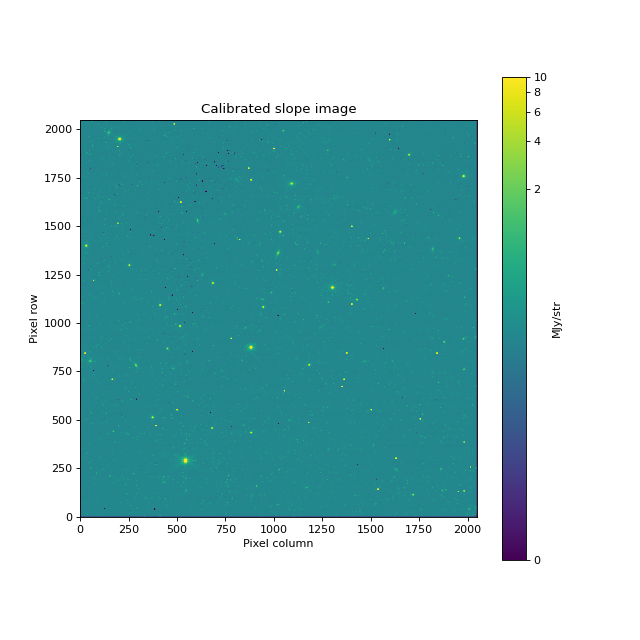

In [21]:
show_image(cal_data['SCI'].data, 0., 10, title='Calibrated slope image')

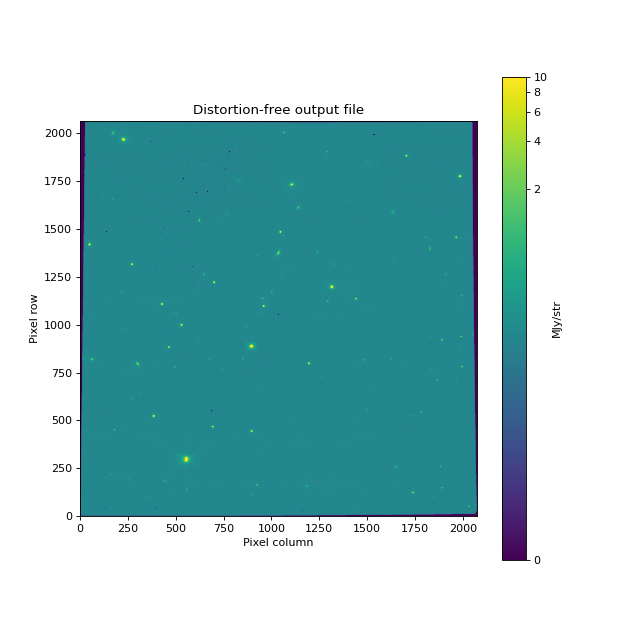

In [22]:
show_image(i2d_data, 0, 10, title="Distortion-free output file")

[Top of Page](#title_ID)

<a id='image2_step_by_step'></a>
# Run the individual pipeline steps

In the sections below we run the steps contained within calwebb_image2 one at a time, in order to more clearly see what each step is doing.

<a id='assign_wcs'></a>
### The `WCS creation` step

#### Summary

This step adds a World Coordinate System (WCS) object to the observation. The WCS object contains transformations between positions on the detector to positions in a world coordinate frame.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/assign_wcs/main.html) of the step.

#### Arguments

There are no optional arguments for this step.

#### Reference files used

The [reference files used](https://jwst-pipeline.readthedocs.io/en/stable/jwst/assign_wcs/reference_files.html) in this step depend on the instrument used. The primary reference file used is the `DISTORTION` reference file, which contains coefficients that can be used to translate between various coordinate systems.

#### Run the step

The assign_wcs step expects an instance of an ImageModel as input, rather than an association file or fits file. So in this case we'll loop over the input files, read them into ImageModel instances, and call the step. Results will be saved to fits files.

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

In [23]:
# for filename in input_files:
#     image = datamodels.ImageModel(filename)
    
#     assign_wcs_step = AssignWcsStep()
#     assign_wcs_step.output_dir = output_dir
#     assign_wcs_step.save_results = True
#     assign_wcs_step.run(filename)

In [24]:
# When the output is saved, the assign_wcs step will
# attach a suffix of 'assignwcsstep' to the input filename.
assign_wcs_output_files = sorted(glob(os.path.join('./', '*assign_wcs.fits')))

#with datamodels.open(output_files[0].replace('cal.fits', 'assign_wcs.fits')) as model:
model = datamodels.open(output_files[0].replace('cal.fits', 'assign_wcs.fits'))
print(model.info())

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.11.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 6e19f27e0503120f19a72814de7157f209c7e9144c952db81630a0dbfb011a40
├─data (NDArrayType): shape=(2048, 2048), dtype=float32
├─dq (NDArrayType): shape=(2048, 2048), dtype=uint32
├─err (NDArrayType): shape=(2048, 2048), dtype=float32
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─asn (dict) ...
│ ├─bunit_data (str): DN/s
│ ├─bunit_err (str): DN/s
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ ├─calibration_software_version (str): 1.4.3
│ └─20 not shown
├─var_poisson (NDArrayType): shape=(2048, 2048), dtype=float32
└─var_rnoise (NDArrayType): shape=(2048, 2048), dtype=float32
Some nodes not shown.
None


Let's look into the WCS information that this step added to the files

The full GWCS model is contained in the ASDF extension of the file, and can be seen through the `meta` property. 

In [25]:
# Look at the WCS info in the calibrated image model 
model.meta.wcs

<WCS(output_frame=world, input_frame=detector, forward_transform=Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('lon', 'lat')
Model set size: 1
Expression: [0] & [1] | [2] & [3] | [4] | [5] & [6] | [7] | [8] & [9] | [10] & [11] | [12] | [13] & [14] | [15] | [16] | [17]
Components: 
    [0]: <Shift(offset=1.)>

    [1]: <Shift(offset=1.)>

    [2]: <Shift(offset=-1024.5)>

    [3]: <Shift(offset=-1024.5)>

    [4]: <Mapping((0, 1, 0, 1))>

    [5]: <Polynomial2D(5, c0_0=-0., c1_0=0.06287861, c2_0=-0.00000011, c3_0=0., c4_0=-0., c5_0=0., c0_1=0., c0_2=0.0000001, c0_3=0., c0_4=0., c0_5=-0., c1_1=-0.00000072, c1_2=0., c1_3=-0., c1_4=0., c2_1=0., c2_2=0., c2_3=-0., c3_1=-0., c3_2=0., c4_1=-0.)>

    [6]: <Polynomial2D(5, c0_0=0., c1_0=0.00008446, c2_0=0.00000031, c3_0=0., c4_0=0., c5_0=-0., c0_1=0.06317477, c0_2=-0.00000042, c0_3=0., c0_4=-0., c0_5=0., c1_1=-0.00000023, c1_2=0., c1_3=-0., c1_4=-0., c2_1=0., c2_2=0., c2_3=0., c3_1=-0., c3_2=-0., c4_1=0.)>

    [7]: <Mapping((0, 1, 0, 1)

There are several world coordinate systems available in the file. 

In [26]:
# What coordinate frames are available?
model.meta.wcs.available_frames

['detector', 'v2v3', 'v2v3vacorr', 'world']

In [27]:
# What is the input frame of the WCS object?
model.meta.wcs.input_frame

<Frame2D(name="detector", unit=(Unit("pix"), Unit("pix")), axes_names=('x', 'y'), axes_order=(0, 1))>

In [28]:
# What is the output frame of the WCS object?
model.meta.wcs.output_frame

<CelestialFrame(name="world", unit=(Unit("deg"), Unit("deg")), axes_names=('lon', 'lat'), axes_order=(0, 1), reference_frame=<ICRS Frame>)>

Let's create a transformation function to go from detector pixels to location on the sky.

In [29]:
model.meta.wcs(50, 50)

(12.014725289918132, 11.984876929714746)

In [30]:
# Get the transform to go from detector to world coordinates
detector_to_world = model.meta.wcs.get_transform('detector', 'world')
pix_ra, pix_dec = detector_to_world(50, 50)
pix_ra, pix_dec

(12.014725289918132, 11.984876929714746)

And a function for the inverse transformation

In [31]:
world_to_detector = model.meta.wcs.get_transform('world', 'detector')
pix_x, pix_y = world_to_detector(pix_ra, pix_dec)
pix_x, pix_y

(50.01755439818294, 50.01385232659129)

Let's look at the calwebb_image2 pipeline output image from before (the _cal.fits files), and zoom in on an interesting area

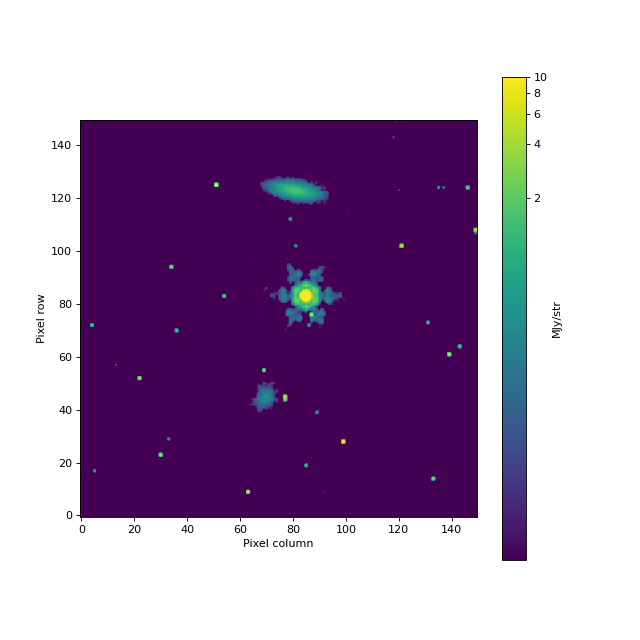

In [32]:
show_image(cal_data[1].data[1000:1150, 860:1010] , 0.3, 10)

Using the transformation functions we defined above, we can now easily determine the RA and Dec of some randomly-chosen sources.

In [33]:
sources_x = [925., 945., 940.]
sources_y = [1045, 1183.2, 1120.5]

In [34]:
# Call the transform function
sources_ra, sources_dec = detector_to_world(sources_x, sources_y)

In [35]:
sources_ra

array([11.99884459, 11.99848432, 11.99857506])

In [36]:
sources_dec

array([12.0024998 , 12.00492301, 12.00382418])

And now the opposite case: My target is at a given RA and Dec, so where is it in this image?

In [37]:
targ_ra = 12.012546822378457
targ_dec = 12.018984533659786

In [38]:
# Call the inverse transform function
targ_x, targ_y = world_to_detector(targ_ra, targ_dec)

In [39]:
print('Target located at (x, y) = ({}, {})'.format(targ_x, targ_y))

Target located at (x, y) = (150.21600840188603, 1982.2179098987947)


<a id='flatfield'></a>
## The `Flat Fielding` step

#### Summary

This step divides the data by a flat field in order to correct for pixel-to-pixel sensitivity variations.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/flatfield/main.html) of the step.

#### Arguments

There is a [single optional argument](https://jwst-pipeline.readthedocs.io/en/stable/jwst/flatfield/arguments.html) for this step, which applies only to NIRSpec data.

#### Reference files used

This step uses the [`FLAT`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/flatfield/reference_files.html) reference file. 

#### Run the step

In this and the subsequent steps, we will loop over the files output by the prceding step and run the step. 

Why not use an association file as input? Because we would need a separate association file for each step since the filenames to be used as input are different in each step. So in order to avoid dealing with many association files, we simply loop over the filenames.

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

In [40]:
# for filename in assign_wcs_output_files:
#     flatfield_step = FlatFieldStep()
#     flatfield_step.output_dir = output_dir
#     flatfield_step.save_results = True

#     flatfield_step.run(filename)

In [41]:
# When the output is saved, the flat field step will
# attach a suffix of 'flatfieldstep' to the input filename.
flatfield_output_files = sorted(glob(os.path.join('./', '*flat_field.fits')))

In [42]:
before_flat = fits.getdata(assign_wcs_output_files[-1])
after_flat = fits.getdata(flatfield_output_files[-1])

# Some pixels were saturated in all groups of the integration.
# This caused them to have a value of 0.0 in the slope image.
# For this display, let's set those pixels equal to 1.0, just
# to get a clearer picture.
zeros = after_flat == 0
before_flat[zeros] = 1.0
after_flat[zeros] = 1.0

# Recover the flat by taking the ratio of the data before and after
# the flat field step
flat_ratio = before_flat / after_flat

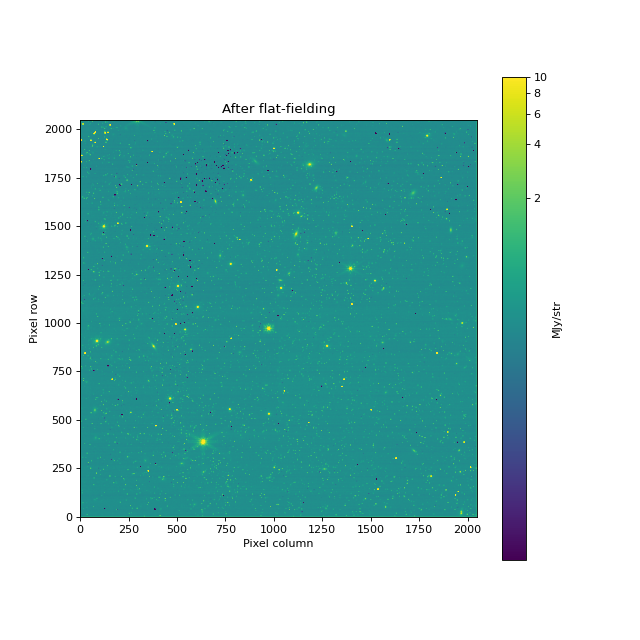

In [43]:
show_image(after_flat , 0.3, 10, title='After flat-fielding')

Taking the ratio of the data before and after the flat field step, we recover the flat field.

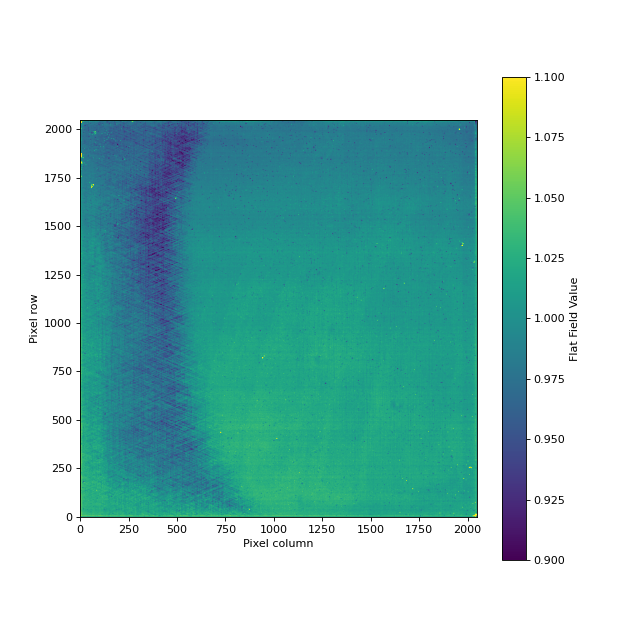

In [44]:
show_image(flat_ratio, 0.9, 1.1, scale='linear', units='Flat Field Value')

<a id='photom'> </a>
## The `Photometric calibration` step

#### Summary

This step applies flux (photometric) calibration to the data, converting it from units of ADU/sec to surface brightness. A conversion factor is retrieved from the `PHOTOM` reference file, and the pixel values in the science data are multiplied by this factor. The factor is also saved in the `PHOTMJSR` keyword within the header of the exposure file. The map of relative pixel areas is also appended to the exposure in a new extension called `AREA`. The average pixel area in units of steradians and square arcseconds is also saved in the science extension header, in the `PIXAR_SR` and `PIXAR_A2` keywords.


#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/photom/main.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step uses the [`PHOTOM` and `AREA`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/photom/reference_files.html) reference files. The `PHOTOM` reference file contains a table of conversion factors that depend on filter. The `AREA` reference file contains a map of the relative pixel areas across the detector.


#### Run the step

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

In [45]:
# for filename in flatfield_output_files:
#     photom_step = PhotomStep()
#     photom_step.output_dir = output_dir
#     photom_step.save_results = True
#     photom_step.run(filename)

Let's look at the new information that was added to the output file. 

In [46]:
# When the output is saved, the photom step will
# attach a suffix of 'photomstep' to the input filename.
photom_output_files = sorted(glob(os.path.join('./', '*photom.fits')))

In [47]:
# Open one of the output files and look at the contents
#with fits.open(photom_output_files[0]) as hdulist:
hdulist = fits.open(photom_output_files[0])
print(hdulist.info())

Filename: ./jw98765001001_01101_00001_nrcb5_photom.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     262   ()      
  1  SCI           1 ImageHDU        85   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [19883B]   


None


In [48]:
# The primary extension header is updated by the photom step
sci_header = hdulist['SCI'].header

And the mean pixel area:

In [49]:
print('Mean pixel area in steradians: {}, and square arcseconds: {}'
      .format(sci_header['PIXAR_SR'], sci_header['PIXAR_A2']))

Mean pixel area in steradians: 9.33676246141109e-14, and square arcseconds: 0.003972341489354567


In [50]:
# Let's pull out the science data and the newly-attached AREA extension
area_map = hdulist['AREA'].data
photom_science_data = hdulist['SCI'].data
hdulist.close()

Note the new `AREA` extension. Let's have a look:

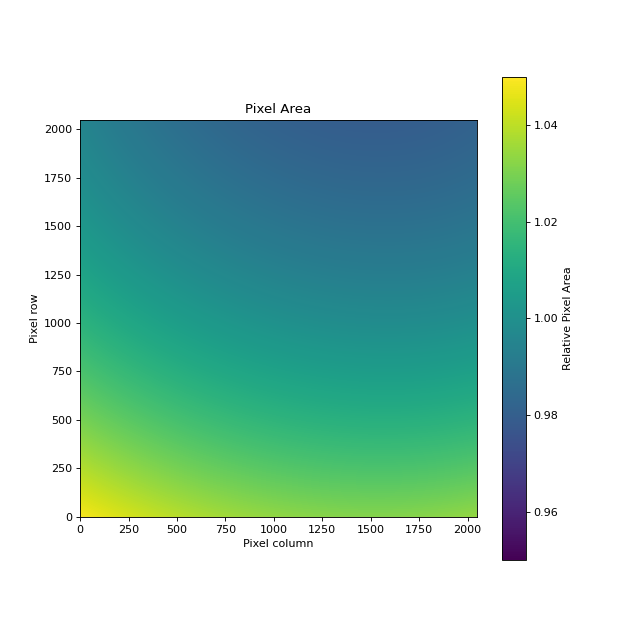

In [51]:
show_image(area_map, 0.95, 1.05, scale='linear', units='Relative Pixel Area', title='Pixel Area')

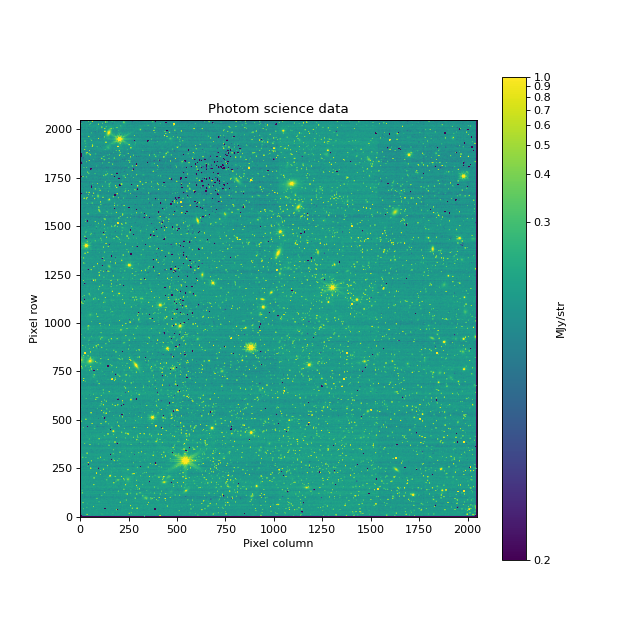

In [52]:
show_image(photom_science_data, 0.2, 1.0, title='Photom science data')

<a id='resample'> </a>
## The `Resample` step

#### Summary

This step resamples the calibrated slope image onto a distortion-free pixel grid. The output is a file with the suffix `_i2d.fits`. This file is for user-examination only. In the Stage 3 pipeline, the resample step will be called again when combining multiple images and creating the final, distortion-free mosaic image.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/main.html) of the step.

#### Arguments

There is a list of [optional Astrodrizzle-style](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/arguments.html) input parameters that can be used to customize the resampling process.

#### Reference files used

This step uses the [`DRIZPARS`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/resample/reference_files.html) reference file. This file contains Astrodrizzle-style keywords that can be used to control the details of the resampling.

#### Run the step

Since we ran the step above and saved the outputs, we'll skip this part and just load the outputs. 

Let's see what parameters are available:

In [53]:
print(ResampleStep.spec)


        pixfrac = float(default=1.0)
        kernel = string(default='square')
        fillval = string(default='INDEF')
        weight_type = option('ivm', 'exptime', default='ivm')
        output_shape = int_list(min=2, max=2, default=None)  # [x, y] order
        crpix = float_list(min=2, max=2, default=None)
        crval = float_list(min=2, max=2, default=None)
        rotation = float(default=None)
        pixel_scale_ratio = float(default=1.0) # Ratio of input to output pixel scale
        pixel_scale = float(default=None) # Absolute pixel scale in arcsec
        single = boolean(default=False)
        blendheaders = boolean(default=True)
        allowed_memory = float(default=None)  # Fraction of memory to use for the combined image.
    


In [54]:
# for filename in photom_output_files:
#     resample_step = ResampleStep()
#     resample_step.output_dir = output_dir
#     resample_step.save_results = True
#     resample_step.run(filename)

In [55]:
# When the output is saved, the resample step will
# attach a suffix of 'resamplestep' to the input filename.
resample_output_files = sorted(glob(os.path.join('./', '*i2d.fits')))

In [56]:
# Extract the data from the three resampled output files so we can look
# at the data
resample_data_0 = fits.getdata(resample_output_files[0])
resample_data_1 = fits.getdata(resample_output_files[1])
resample_data_2 = fits.getdata(resample_output_files[2])

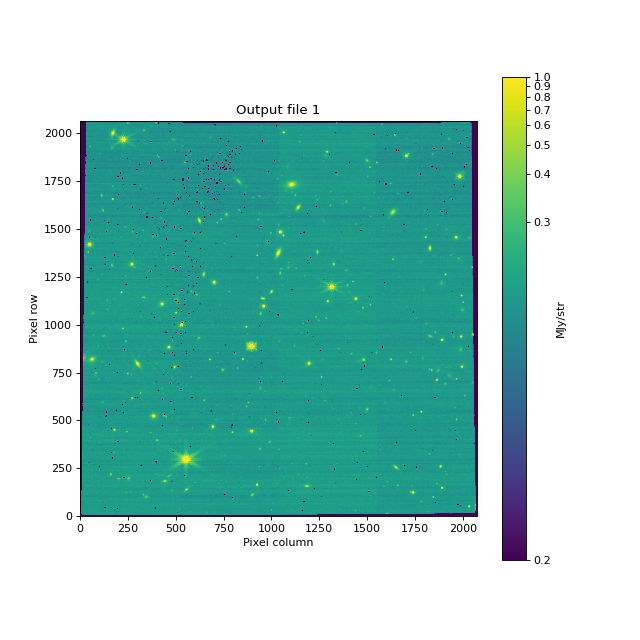

In [57]:
show_image(resample_data_0, 0.2, 1.0, title='Output file 1')

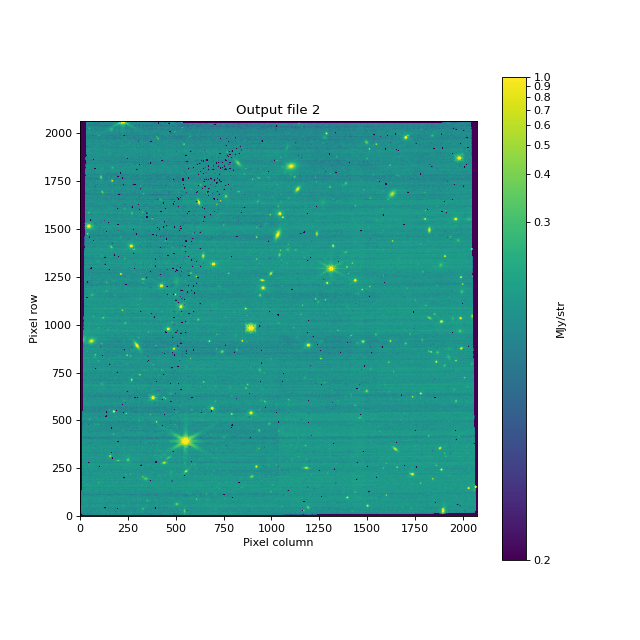

In [58]:
show_image(resample_data_1, 0.2, 1.0, title='Output file 2')

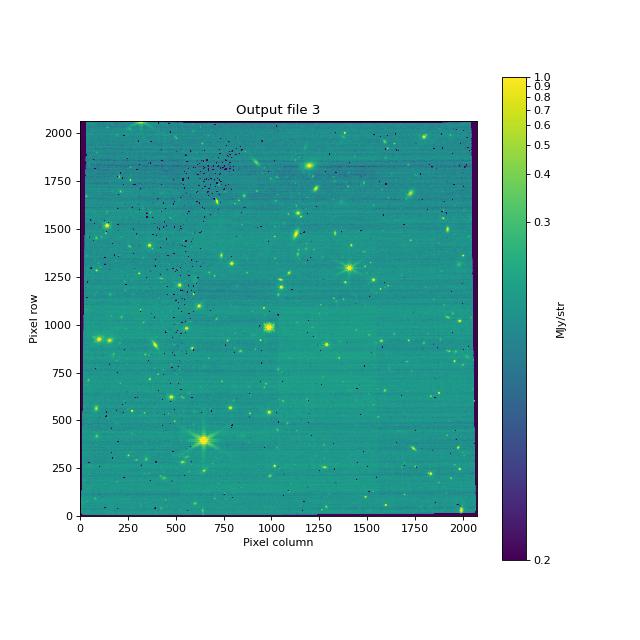

In [59]:
show_image(resample_data_2, 0.2, 1.0, title='Output file 3')

Now let's compare this to the data immediately prior to the resample step, in order to highlight the difference.

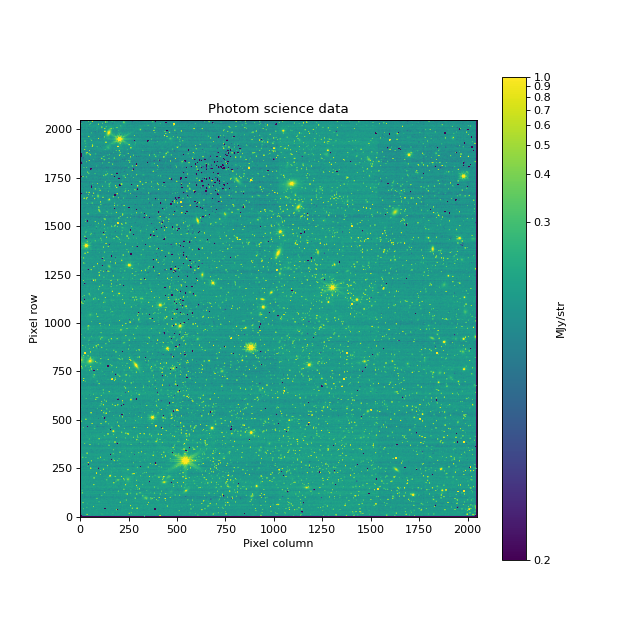

In [60]:
show_image(photom_science_data, 0.2, 1.0, title='Photom science data')

Notice that the array size has changed:

In [61]:
print(photom_science_data.shape)

(2048, 2048)


In [62]:
print(resample_data_0.shape)

(2067, 2074)


[Top of Page](#title_ID)

<a id="about_ID"></a>
## About this Notebook
**Original Author:** Bryan Hilbert, updated by Alicia Canipe, NIRCam
<br>**Updated On:** 07/28/2021

[Top of Notebook](#title_ID)